In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### PART 1. Predicting economy growth by sectors using stocks prices.

In [171]:
cd drive/My Drive/Project ML

[Errno 2] No such file or directory: 'drive/My Drive/Project ML'
/content/drive/My Drive/Project ML


In [0]:
sec_ch = pd.read_excel('Sectors.xlsx') #economyc parameters by sectors
st_ch = pd.read_excel('Monthly_changes.xlsx') #monthly stocks changes by sectors

In [0]:
sec_ch_1 = sec_ch.iloc[1:, [1] + list(range(21,sec_ch.shape[1]))].dropna(axis = 0, how = 'any')
sec_ch_1.columns = ['Date'] + list(sec_ch.iloc[1, 21:])
sec_ch_f = sec_ch_1.reset_index(drop=True, inplace=False)


In [0]:
gzp_st = pd.read_csv('GAZP_150101_191231.csv') #stocks of Gazprom
nvtk_st = pd.read_csv('NVTK_150101_191231.csv') #stocks of Novatek

In [0]:
def year_month(date):
  '''This function makes date appropriate for futher processing'''
  date = str(date)
  return f"{date[:4]}/{date[4:6]}"

In [0]:
gzp_st['Year_month'] = gzp_st['<DATE>'].apply(lambda x: year_month(x))

In [0]:
gas_st = pd.DataFrame({'Year_month': gzp_st['Year_month'], 'gazp_cl': gzp_st['<CLOSE>'], 'nvtk_cl': nvtk_st['<CLOSE>']}) #create 
                                                                  #one table with stocks of gaz companies

In [0]:
month_st_gas = gas_st[['gazp_cl', 'Year_month', 'nvtk_cl']].groupby(['Year_month']).mean() #compute average stocks prices by mounthes

In [0]:
month_st_gas['dif_gazp'] = month_st_gas['gazp_cl'].diff() # these two lines of code computes stocks mounthly changes
month_st_gas['dif_nvtk'] = month_st_gas['nvtk_cl'].diff()

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()
gazp = np.array(month_st_gas['dif_gazp']).reshape(len(month_st_gas['dif_gazp']), 1)
nvtk = np.array(month_st_gas['nvtk_cl']).reshape(len(month_st_gas['nvtk_cl']), 1)

d_2 = np.array(sec_ch_f['ENGC3_SA']).reshape(len(sec_ch_f['ENGC3_SA']), 1)

stocks_g = scaler.fit(gazp).transform(gazp)
stocks_n = scaler.fit(nvtk).transform(nvtk)

final = (stocks_g + stocks_n)
economy = scaler.fit(d_2).transform(d_2)


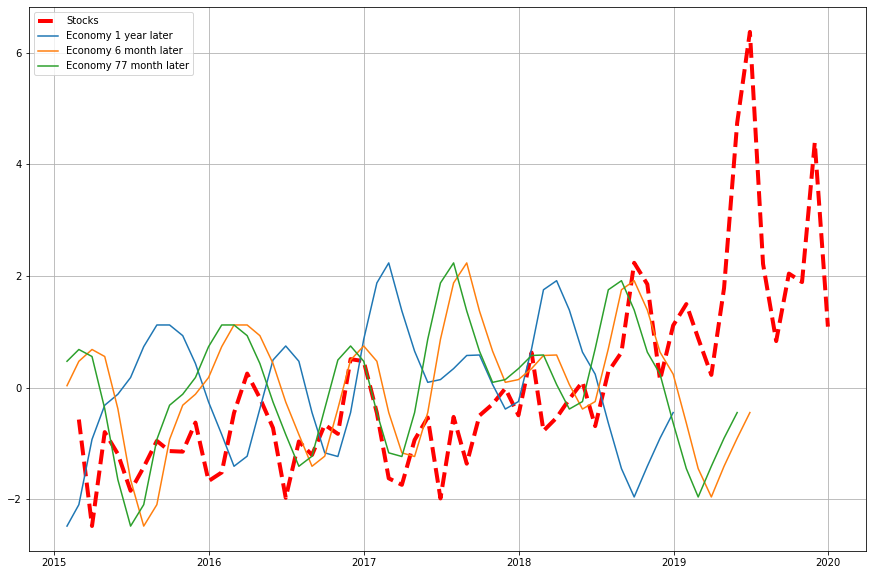

In [182]:
plt.figure(figsize=(15,10))
plt.plot(sec_ch_f['Date'], final, 'r--', label = 'Stocks', linewidth = 4)
plt.plot(sec_ch_f['Date'][:48], economy[12:], label = 'Economy 1 year later')
plt.plot(sec_ch_f['Date'][:54], economy[6:], label = 'Economy 6 month later')
plt.plot(sec_ch_f['Date'][:53], economy[7:], label = 'Economy 77 month later')

plt.grid()
plt.legend()
plt.show()

In [0]:
from scipy.stats.stats import pearsonr

In [0]:
def maximum_correlation(a,b):
    ''' Maybe stocks prices affects on economy growth with some decay. To figure it out we decided to find such i which provides 
    maximum Pearson correalation value. We'll use this function later for the same purpose but with other economy parameters'''
    a = np.array(a).reshape(-1)
    b = np.array(b).reshape(-1)
    cors=[]
    for i in range(0, 30):
        cors.append(pearsonr(a[i:],b[:len(b) - i]))  ##i + 1 inasmuch as zero's row equalt to NaN after diff()
    cors_np=np.argmax(cors, axis=0)
    return min(cors_np), cors[cors_np[0]]

In [185]:
maximum_correlation_stocks(economy[i+1:], final[1:60-i]) ##we are starting from 1 inasmuch as zero's row equalt to NaN after diff()

(9, (0.33662826162435017, 0.06406821085970917))

As one can see from the chart above and value of maximum Pearson correlation, there is no strong connection between stocks prices and related economy sector growth.

### PART 2. Predicting sector growth by working hours

In [0]:
sav = pd.read_excel('Sectors_abs_values2 (2).xlsx') #economyc parameters by sectors
ehv = pd.read_excel('Employment hours_values2.xlsx') #employment hours

In [0]:
sav['Gas']=sav['Gas'].apply(lambda x: x*0,77*1154/1430) # m3 to tonn, tons of conventional fuel gas/oil 
sav['Mining'] = sav['Oil'] + (sav['Gas'])
sav = sav.drop(columns=['Oil', 'Gas'])
sav = sav.rename(columns={"Unnamed: 0": "Date", "M2": "Banking"}, errors="raise")

ehv = ehv.rename(columns={"Unnamed: 0": "Date","Manufacturing": "Metals"} ,errors="raise")
cols = ehv.columns.tolist()
sav = sav[cols]

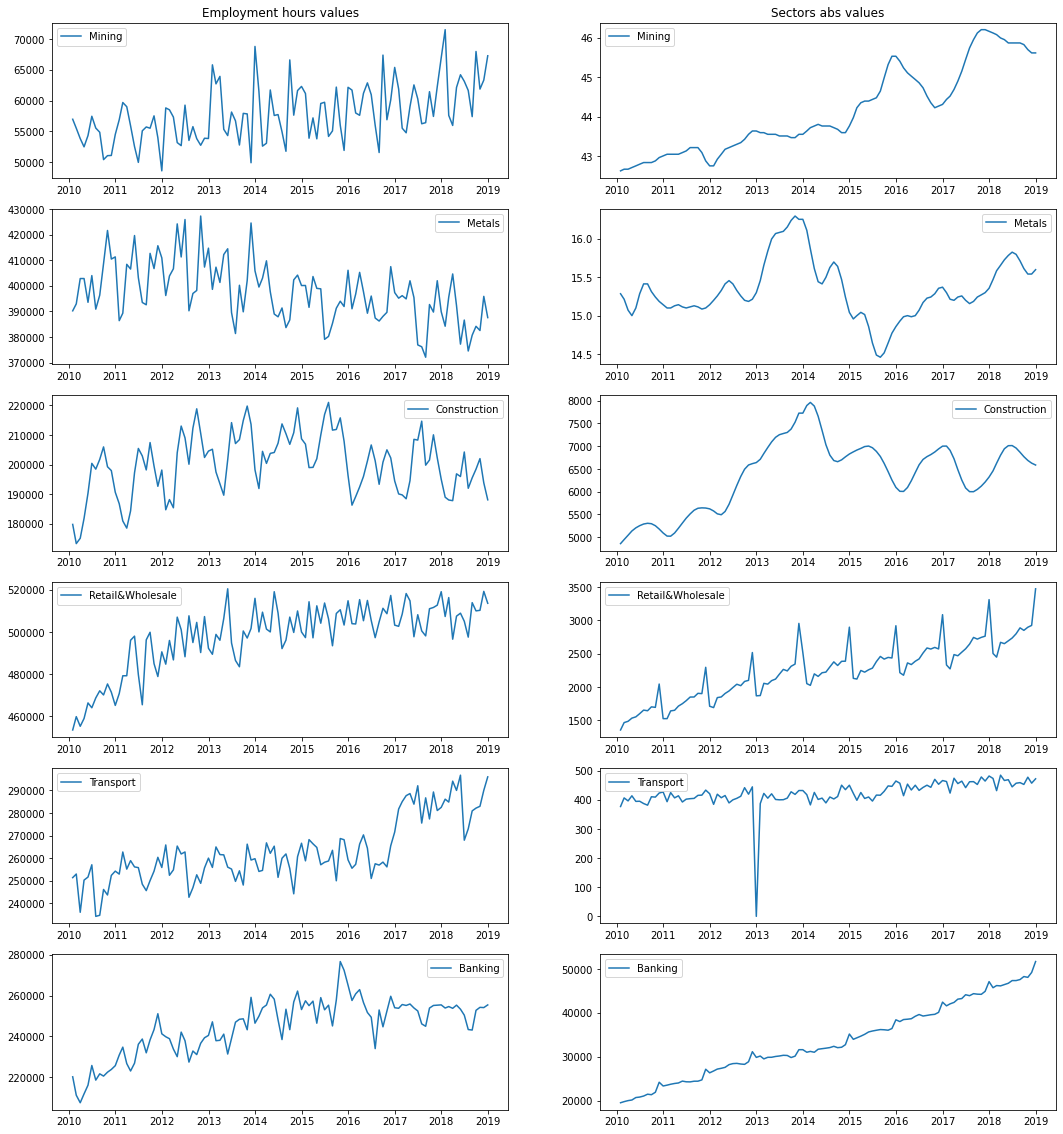

In [188]:
f, axes = plt.subplots(6, 2, sharex=False, figsize=(18, 20))
axes[0, 0].set_title('Employment hours values')
axes[0, 1].set_title('Sectors abs values')


for i, column in zip([i for i in range(0, len(cols) - 1)], cols[1:]):
#  print(i, column)
  axes[i, 0].plot(ehv['Date'], ehv[column], label = column)
  axes[i, 1].plot(ehv['Date'], sav[column][13:], label = column) #ehv predicts sav
  axes[i, 0].legend()
  axes[i, 1].legend()

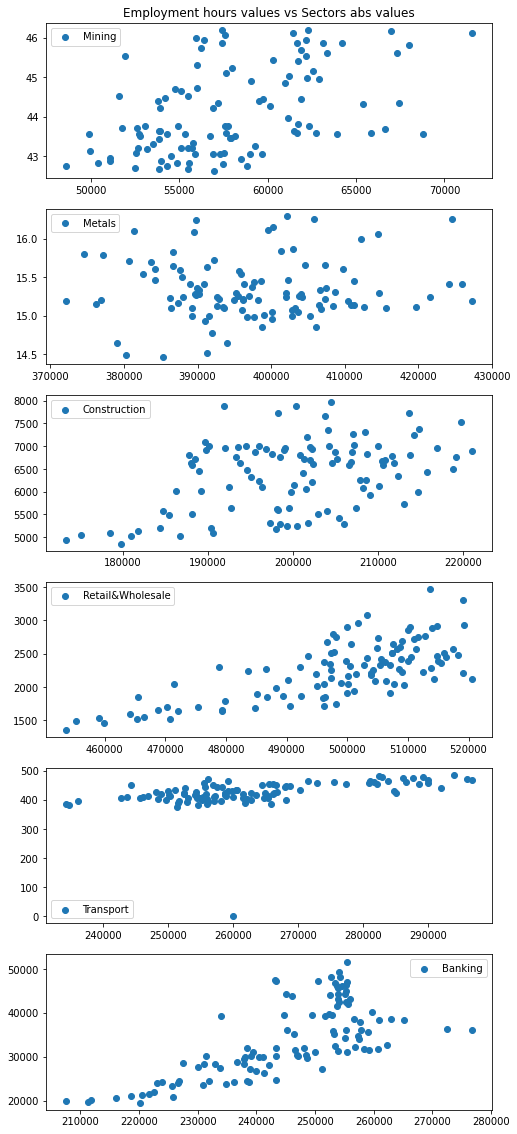

In [189]:
f, axes = plt.subplots(6, 1, sharex=False, figsize=(8, 20))
axes[0].set_title('Employment hours values vs Sectors abs values')



for i, column in zip([i for i in range(0, len(cols) - 1)], cols[1:]):
#  print(i, column)
 
  axes[i].scatter(ehv[column], sav[column][13:], label = column)
  axes[i].legend()



In [0]:
def maximum_correlation(a,b):
    a = np.array(a).reshape(-1)
    b = np.array(b).reshape(-1)
    cors=[]
    for i in range(0, 30):
        cors.append(pearsonr(a[i:],b[:len(b) - i]))
    cors_np=np.argmax(cors, axis=0)
    return min(cors_np), cors[cors_np[0]]

In [0]:
decays = {col: maximum_correlation(ehv[col],sav[col][:-13])[0] for col in cols[1:] for col in cols[1:]} # obtain dictionary which contains
            #sector names as keays and indexes which provide the highest pearson correlation value as values

In [192]:
decays

{'Banking': 0,
 'Construction': 0,
 'Metals': 0,
 'Mining': 0,
 'Retail&Wholesale': 5,
 'Transport': 1}

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [0]:
models = []
scores = {}
scalar = StandardScaler()
predictions = {}

for i, column in zip([i for i in range(0, len(cols) - 1)], cols[1:]):
    d = decays[column]
    if d != 0:
      e = np.array(ehv[column][:-d]).reshape(-1, 1)
      a = np.array(sav[column][d:-13]).reshape(-1, 1)
    else:
      e = np.array(ehv[column]).reshape(-1, 1)
      a = np.array(sav[column][:-13]).reshape(-1, 1)

    models.append((LinearRegression().fit(e, a)))

    predictions[column + '_pred'] = models[i].predict(e).reshape(len(e), 1)

    scores[column] = models[i].score(e, a)

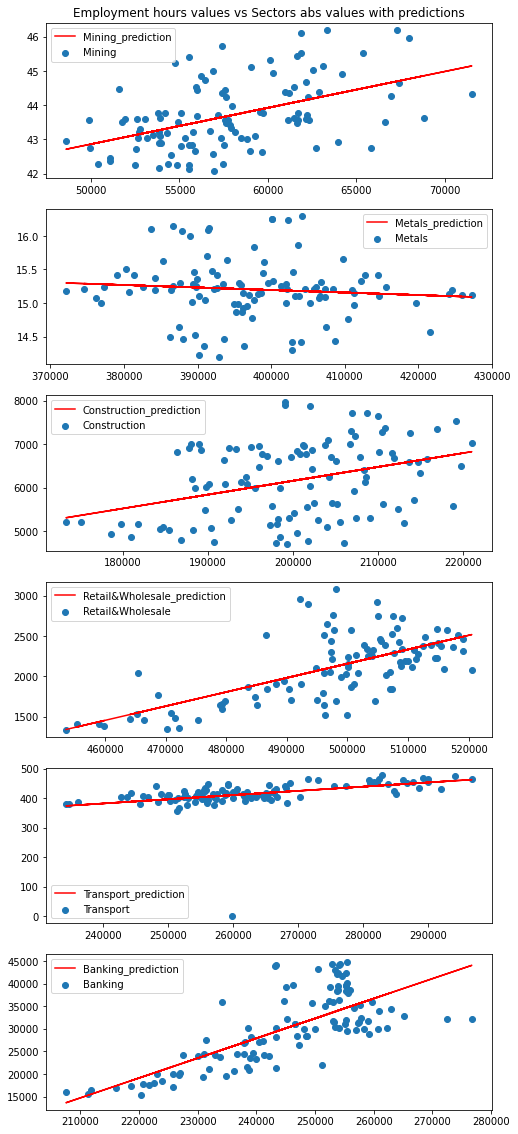

In [195]:
f, axes = plt.subplots(6, 1, sharex=False, figsize=(8, 20))
axes[0].set_title('Employment hours values vs Sectors abs values with predictions')



for i, column in zip([i for i in range(0, len(cols) - 1)], cols[1:]):
  d = decays[column]
  if d != 0:
    axes[i].scatter(ehv[column][:-d], sav[column][d:-13], label = column)
    axes[i].plot(ehv[column][:-d], predictions[column + '_pred'], 'r', label = column + '_prediction')
    axes[i].legend()
  else:
    axes[i].scatter(ehv[column], sav[column][:-13], label = column)
    axes[i].plot(ehv[column], predictions[column + '_pred'], 'r', label = column + '_prediction')
    axes[i].legend()

In [196]:
scores

{'Banking': 0.5465529495334331,
 'Construction': 0.13544438389737246,
 'Metals': 0.009079503829263036,
 'Mining': 0.23567489556424437,
 'Retail&Wholesale': 0.45270011635888696,
 'Transport': 0.1639907958473228}

### PART 3. COVID index regression

In [0]:
res = pd.read_csv('res.csv')
sap = pd.read_csv('SANDP-FUT_200121_200330.csv')

In [0]:
sap['date-time'] = sap['<DATE>'].astype(str) + sap['<TIME>'].astype(str)

In [0]:
def make_same(S):
  return S[:4] + '-' + S[4:6] + '-' + S[6:8] + ' ' + S[8:10] + ':' + S[10:12] + ':' + S[12:14]


In [0]:
sap['datetime'] = sap['date-time'].apply(lambda x: make_same(x))

In [0]:
sap = sap.drop(['<DATE>',	'<TIME>', 'date-time'], axis = 1)

In [0]:
r_s = res['datetime']
s_s = sap['datetime']
l_u = list(set(r_s) & set(s_s))

In [0]:
res_s = res.loc[res['datetime'].isin(l_u)]
sap_s = sap.loc[sap['datetime'].isin(l_u)]

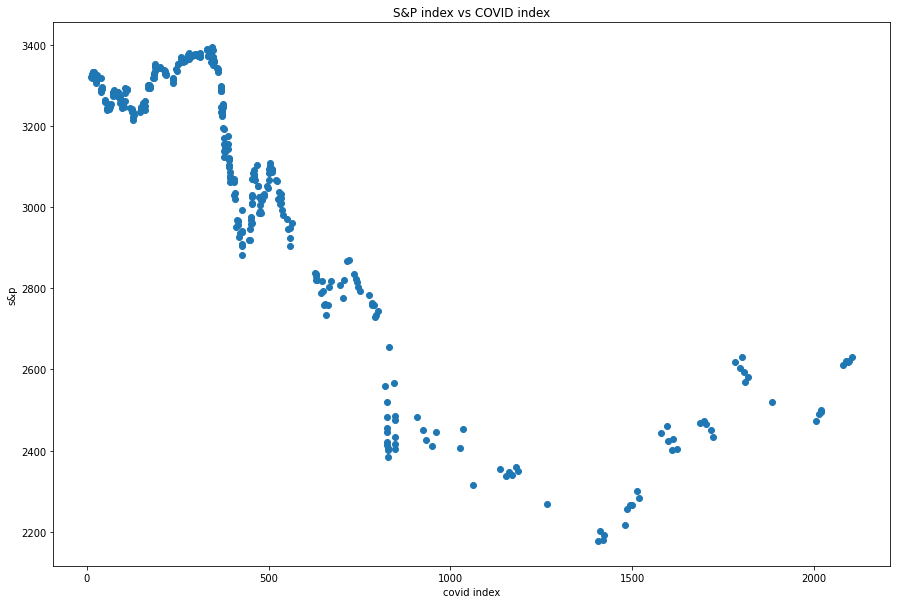

In [204]:
plt.figure(figsize=(15,10))
plt.title('S&P index vs COVID index')
plt.xlabel('covid index')
plt.ylabel('s&p')
plt.scatter(res_s['value'], sap_s['<CLOSE>'])
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [206]:
scalar = StandardScaler()
poly = PolynomialFeatures(4)
x = np.array(res_s['value']).reshape(len(res_s['value']), 1)
y = np.array(sap_s['<CLOSE>']).reshape(len(sap_s['<CLOSE>']), 1)

print(x.shape)
x_scaled = scalar.fit(x).transform(x)
x_tr =  poly.fit_transform(x_scaled)


reg = LinearRegression().fit(x_tr, y)

prediction = reg.predict(x_tr)
reg.score(x_tr, y)


(370, 1)


0.9307106593433108

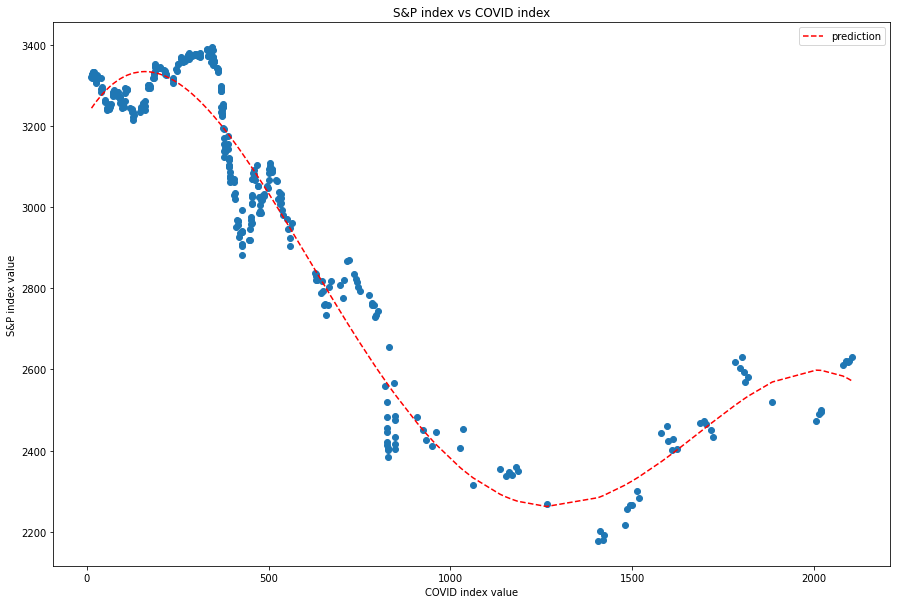

In [207]:
plt.figure(figsize=(15,10))
plt.title('S&P index vs COVID index')
plt.scatter(x, y)
plt.plot(x, prediction, 'r--', label = "prediction")
plt.xlabel("COVID index value")
plt.ylabel('S&P index value')
plt.legend()
plt.show()